In [ ]:
import os
import json
import argparse
import numpy as np
from config import DATA_DIR
import h5py
from utils import flatten_list, save_data
import config, consts, paths
from encoding.ridge import bootstrap_ridge
from decoding.StimulusModel import StimulusModel, get_lanczos_mat, affected_trs, LMFeatures
from decoding.utils_stim import predict_word_rate, predict_word_times
from decoding.utils_resp import get_resp, get_resp_test
from utils import nsort, flatten_list
from decoding.GPT import GPT
from encoding.npp import zscore
from decoding.Decoder import Decoder, Hypothesis
from decoding.LanguageModel import LanguageModel
from decoding.EncodingModel import EncodingModel
from himalaya.kernel_ridge import KernelRidgeCV
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
from sklearn.pipeline import make_pipeline
from voxelwise_tutorials.utils import generate_leave_one_run_out
from sklearn.model_selection import check_cv
import cortex
import numpy as np
import matplotlib.pyplot as plt


In [2]:
stories = flatten_list(consts.STORIES)
stimuli = stories
modality = "story"
goal = "UTS03"
exclude = None
references = ["UTS02"]#, "UTS03" "UTS09"]

In [ ]:
def get_reverse_corrs(goal, references, resp, cache = None):
    """select goal voxels by fitting reverse converters from references to goal
    """
       
    # fit converters from references to goal
    rconverters = {}
    for reference in references:
        rvox = np.load(paths.EM % reference, allow_pickle = True).item()['voxels']
        gresp_align = resp[goal]
        rresp_align = resp[reference][:, rvox]
        converter, _, _ = bootstrap_ridge(rresp_align, gresp_align, alphas = config.ALPHAS,
                nboots = config.NBOOTS, chunklen = config.CHUNKLEN, use_corr = True, seed = 42)            
        rconverters[reference] = (converter, rvox)        

    # compare aligned responses across converters
    stories = flatten_list(consts.STORIES[3:])
    reverse_corrs = []
    for story in stories:
        rsim = []
        for reference in references:
            rvox = rconverters[reference][1]
            rresp = get_resp(reference, [story], "story", stack = True, voxels = rvox)
            rsim.append(zscore(rresp.dot(rconverters[reference][0])))
        for c1 in range(len(rsim)):
            for c2 in range(c1+1, len(rsim)):
                reverse_corrs.append((rsim[c1] * rsim[c2]).mean(0))
    return np.mean(reverse_corrs, axis = 0)


In [ ]:
run_on_set = []
for story in stories:
		temp= config.DATA_DIR+'/derivative/preprocessed_data/'+references[0]
		resp_path = os.path.join(temp,"%s.hf5" % story)
		hf = h5py.File(resp_path, "r")
		if not run_on_set:
			run_on_set.append(hf["data"][:].shape[0])
		else:
			run_on_set.append(run_on_set[-1]+hf["data"][:].shape[0])
		hf.close()
run_on_set=run_on_set[:-1]

In [4]:
# load converter data
resp_align = {}
for subject in consts.SUBJECTS:
    #resp_full = get_resp(subject, stories, "story", stack = True)
    resp_align[subject] = get_resp(subject, stimuli, modality, stack = True)
reverse_corrs = get_reverse_corrs(goal, [subject for subject in consts.SUBJECTS if subject != goal], resp_align)
if exclude is not None:
    exclude_mask = np.load(paths.ROI % (goal, exclude))
    reverse_corrs[exclude_mask] = -1
gvox = nsort(np.argsort(reverse_corrs)[-15000:])

[]


/opt/anaconda3/envs/naturalistic/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/naturalistic/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
reference ="UTS02"
rvox = np.load(paths.EM % reference, allow_pickle = True).item()['voxels']
gresp_align = resp_align[goal][:, gvox]
rresp_align = resp_align[reference][:, rvox]
converter, _, allRcorrs = bootstrap_ridge(gresp_align, rresp_align, alphas = config.ALPHAS, 
        nboots = config.NBOOTS, chunklen = config.CHUNKLEN, use_corr = True, seed = 42)  

In [5]:
# train converters
converters = {}
for reference in references:
    rvox = np.load(paths.EM % reference, allow_pickle = True).item()['voxels']
    gresp_align = resp_align[goal][:, gvox]
    rresp_align = resp_align[reference][:, rvox]
    converter, _, allRcorrs = bootstrap_ridge(gresp_align, rresp_align, alphas = config.ALPHAS, 
            nboots = config.NBOOTS, chunklen = config.CHUNKLEN, use_corr = True, seed = 42)            
    converters[reference] = (converter, gvox, rvox)     

# train model 

In [40]:
X_train = np.array(gresp_align, dtype=float)
#X_test = np.array(rresp_align, dtype=float)
print("(n_samples_train, n_features) =", X_train.shape)
#print("(n_samples_test, n_features) =", X_test.shape)

(n_samples_train, n_features) = (1869, 1)


In [41]:
Y_train = np.array(rresp_align, dtype=float)
#Y_test = np.array(Y_test, dtype=float)
print("(n_samples_train, n_voxels) =", Y_train.shape)
#print("( n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_train, n_voxels) = (1869, 10000)


In [42]:
n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, run_on_set)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

In [43]:
X_train_= X_train.astype("float32")
alphas = np.logspace(1, 20, 20)

In [44]:
pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                           n_targets_batch_refit=100)),
)

In [45]:
_ = pipeline.fit(X_train, Y_train)

/opt/anaconda3/envs/naturalistic/lib/python3.12/site-packages/himalaya/kernel_ridge/_sklearn_api.py:490: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1869 > 4). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  warnings.warn(


In [46]:
scores_train = pipeline.score(X_train, Y_train)
print("(n_voxels train,) =", scores_train.shape)

(n_voxels train,) = (10000,)


Text(0.5, 0, 'R-squared')

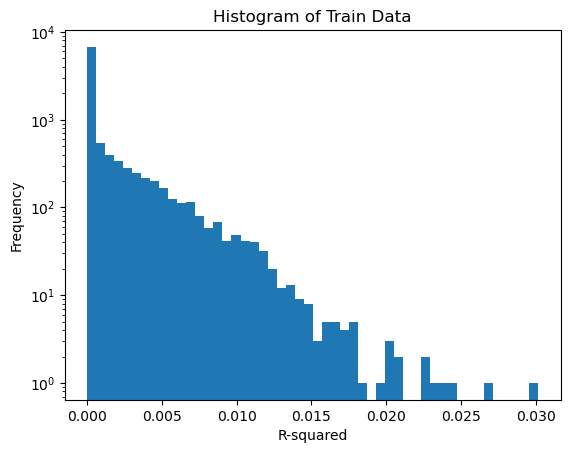

In [47]:
import matplotlib.pyplot as plt
plt.hist(scores_train, bins=50, log=True)
plt.title("Histogram of Train Data")
plt.ylabel("Frequency")
plt.xlabel("R-squared")

# enbedding not needed 

In [ ]:
# load responses
gresp = get_resp_test(goal, repeat = "first")
# load models
em = {}
wr_data = []
for reference in references:
    wr_data.append(np.load(paths.WR % reference, allow_pickle = True).item())
    em_data = np.load(paths.EM % reference, allow_pickle = True).item()
    converter, gvox, rvox = converters[reference]
    rresp = np.nan_to_num(zscore(gresp[:, gvox].dot(converter)))
    em[reference] = EncodingModel(rresp, em_data["weights"], em_data["noise_model"], device = "cuda")
    em[reference].set_shrinkage(config.NM_ALPHA)
    tr_stats, word_stats = np.array(em_data["tr_stats"]), em_data["word_stats"][0]

In [ ]:
# predict word times
with open(os.path.join(config.DATA_TRAIN_DIR, "ROIs", f"{goal}.json"), "r") as f:
    roi_vox = json.load(f)
starttime = -10
word_rate = predict_word_rate(gresp, roi_vox, wr_data)
word_times, tr_times = predict_word_times(word_rate, gresp, starttime = starttime)
lanczos_mat = get_lanczos_mat(word_times, tr_times)